#### Overall flow
```
Generated embeddings for the hotels posts using a sentence BERT model, 
Calculates the centriods for the truthful and deceptive embeddings from the training set
Assigns labels to the test set data based on the similarity to the centroids
```

In [3]:
import chromadb
from chromadb.config import Settings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from sentence_transformers import SentenceTransformer
model_name = 'all-distilroberta-v1'  # We chose this model because the sequence length is 512
# model_name = 'all-MiniLM-L6-v2'  # alter model with sequence length of 512
model = SentenceTransformer(model_name)
print(f"Max Sequence Length for model, {model_name}: {model.max_seq_length}")

sentence_transformer_ef = SentenceTransformerEmbeddingFunction(model_name=model_name)

print(f'Default embedding function: {sentence_transformer_ef}')
client = chromadb.Client(Settings(persist_directory="./spam-db")) # Does persistence work??


# collection = client.create_collection(name="spam-dataset")
collection = client.create_collection(
        name="spam-dataset",
        embedding_function=sentence_transformer_ef,
        metadata={"hnsw:space": "cosine"} # l2 is the default
    )
print(f'collection count: {collection.count()}')

Max Sequence Length for model, all-distilroberta-v1: 512


Using embedded DuckDB without persistence: data will be transient


Default embedding function: <chromadb.utils.embedding_functions.SentenceTransformerEmbeddingFunction object at 0x7f9836fa2c40>
collection count: 0


In [4]:
import os
import sys
import numpy as np

# Add the parent directory of the project to the sys.path
project_dir = os.path.abspath(os.path.join(os.path.dirname('.'), ".."))
sys.path.append(project_dir)

from utils.read_gold_dataset import collect_all_files, read_a_file, get_gt_from_file_name, filter_files

root_dir = '../spam-dataset/op_spam_v1.4'
file_path_list = collect_all_files(root_dir, 'truthful')
file_path_list += collect_all_files(root_dir, 'deceptive')
total_samples = len(file_path_list)
print(f'Total samples: {total_samples}')



Total samples: 1600


In [5]:
def get_embedding(file_path):
    _, veracity, text = read_a_file(file_path)
    # print(f'read file in get_embedding: {text}')
    # sentence_transformer_ef([text])
    return sentence_transformer_ef([text]), veracity

def get_mean_embedding(file_path_list):
    embeddings = []
    for i, file_path in enumerate(file_path_list):
        _, _, text = read_a_file(file_path)
        # print(f'index {i}: file name: {file_path}: text\n {text}')
        embeddings.append(sentence_transformer_ef([text])[0])
    return np.mean(embeddings, axis=0)

In [6]:
# test/train split
from sklearn.model_selection import train_test_split
import pprint

# Splitting the dataset into training and testing sets
train_files, test_files = train_test_split(file_path_list, test_size=0.20, random_state=42, shuffle=True)

train_files_truthful = filter_files(train_files, 'truthful')
print(f'Count of truthful training files: {len(train_files_truthful)}')

train_files_deceptive = filter_files(train_files, 'deceptive')
print(f'Count of deceptive training files: {len(train_files_deceptive)}')

truthful_mean_embedding = get_mean_embedding(train_files_truthful)
deceptive_mean_embedding = get_mean_embedding(train_files_deceptive)

# get the top 5 nearest neighbours to each of the means
# top_5 = collection.query([truthful_mean_embedding], n_results=5)
# print(top_5)
# for i in range(5):
#     print(f"ids: {top_5['ids'][0][i]}, centroid embedding: truthful")
#     pprint.pprint(top_5['documents'][0][i])
#     print(f'{"-"*20}')

# top_5 = collection.query([deceptive_mean_embedding], n_results=5)
# for i in range(5):
#     print(f"ids: {top_5['ids'][0][i]}, centroid embedding: deceptive")
#     pprint.pprint(top_5['documents'][0][i])
#     print(f'{"-"*20}')


# # Printing the results
# print(f'Train file count: {len(train_files)}, Training Data: {train_files}')
# print(f'Test file count: {len(test_files)} Testing Data: {test_files}')

Count of truthful training files: 629
Count of deceptive training files: 651


Load into chroma

In [7]:
# do this only once
base = 100
for i, file_path in enumerate(train_files):
    gt_sentiment, gt_veracity, text = read_a_file(file_path)
    ids = ['id' + str(i + base) + gt_veracity ]
    metadatas = [{"source": file_path}]
    # print(ids)
    # print(metadatas)
    collection.add(
        documents = [text],
        metadatas = metadatas,
        ids = ids
    )
print(f'count: {collection.count()}')

count: 1280


In [9]:
import json
# collection.get()
# Only get documents and ids
embeddings = collection.get(include=[ "embeddings" ])["embeddings"]
print(f'Length of Embeddings: {len(embeddings)}')
# mean_embedding_of_set = np.mean(embeddings["embeddings"], axis=0)
# print(f'Dimension of mean embedding: {mean_embedding_of_set.shape}')
# print(mean_embedding_of_set)  
# print(f'Type of embeddings: {embeddings}')

Length of Embeddings: 1280


#### Projection

In [10]:
# import umap
import umap.umap_ as umap
from helper_utils import project_embeddings

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)



/home/auro/anaconda3/envs/babyagi/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 1280/1280 [13:04<00:00,  1.63it/s]


(-0.47738111168146136,
 8.311301203072071,
 2.4661003828048704,
 11.136405777931213)

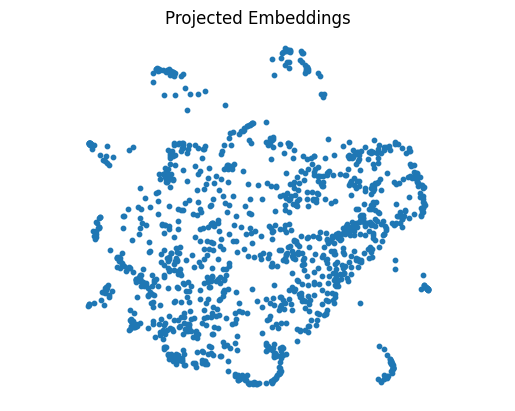

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [12]:
from helper_utils import word_wrap

query_file_name = '../spam-dataset/op_spam_v1.4/negative_polarity/truthful_from_Web/fold2/t_affinia_11.txt'
_, gt_veracity, query = read_a_file(query_file_name)
print(f'QUERY:\n{query}')

results = collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]
print(f'RESPONSES:')
for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

query_embedding = sentence_transformer_ef([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)



QUERY:
We booked this hotel as a last minute vacation planned on doing a little shopping and nightlife downtown. We where woken up at 6:00 in the morning with our bathroom flooded, this water was brown and all the clothing and our belongings left in the bathroom were dirty and sopping wet. We where moved to another room, but it was smaller then the orginal room we had gotten and paid for. The next day the housekeeping service never even came to change our sheets, coffee or towels, which is just horrible service. The service along with the orginal room where perfect, but we do not plan on ever spending another weekend in that flooding hotel.

RESPONSES:
We booked this hotel as a last minute vacation planned on doing a
little shopping and nightlife downtown. We where woken up at 6:00 in
the morning with our bathroom flooded, this water was brown and all the
clothing and our belongings left in the bathroom were dirty and sopping
wet. We where moved to another room, but it was smaller then

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


(-0.47738111168146136,
 8.311301203072071,
 2.4661003828048704,
 11.136405777931213)

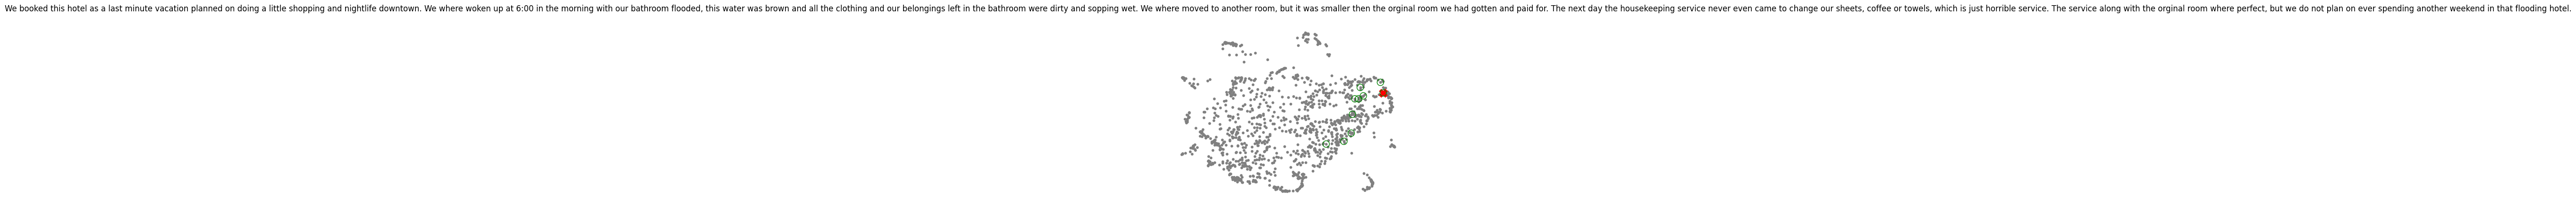

In [13]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

# plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [23]:
# Reranking
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
import numpy as np

pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(f'Index:{o}, Score: {scores[o]:0.2}')

Scores:
7.119552
-4.773519
-5.5011125
0.340693
-1.3714285
-4.0670824
-3.2849526
-3.8342316
-5.4913397
-1.5496321
New Ordering:
0, 7.1
3, 0.34
4, -1.4
9, -1.5
6, -3.3
7, -3.8
5, -4.1
1, -4.8
8, -5.5
2, -5.5


##### Assign class to be the same as nearest neighbor

In [ ]:
import pprint

def get_nearest_neighbor(test_file_name):
    _, gt_veracity, text = read_a_file(test_file_name)
    # pprint.pprint(text)
    # print(f'veracity: {gt_veracity}')
    results = collection.query(
        query_texts= text,
        n_results=1
    )
    # pprint.pprint(results)
    file_nearest_neighbor = results['metadatas'][0][0]['source'] 
    # print(file_nearest_neighbor)
    # extract ground_truth from spam file name
    _, gt_veracity_of_nearest_neighbor = get_gt_from_file_name(file_nearest_neighbor)
    print(f'GT of post:{gt_veracity}, GT of nearest neighbor: {gt_veracity_of_nearest_neighbor}')
    return gt_veracity, gt_veracity_of_nearest_neighbor

test_file_name = '../spam-dataset/op_spam_v1.4/negative_polarity/truthful_from_Web/fold2/t_affinia_11.txt'
_,_ = get_nearest_neighbor(test_file_name)

In [ ]:
gt_veracity_list = []
gt_veracity_of_nearest_neighbor_list = []
for test_file in test_files:
    gt_veracity, gt_veracity_of_nearest_neighbor = get_nearest_neighbor(test_file)
    gt_veracity_list.append(gt_veracity)
    gt_veracity_of_nearest_neighbor_list.append(gt_veracity_of_nearest_neighbor)


In [ ]:
# get a F1-score
from sklearn.metrics import f1_score

# Calculate F1 score
# f1 = f1_score(gt_veracity_list, gt_veracity_of_nearest_neighbot_list)
f1_weighted = f1_score(gt_veracity_list, gt_veracity_of_nearest_neighbor_list, average='weighted')
print("Weighted F1 Score:", f1_weighted)

print("F1 Score:", f1_weighted)


#### Assign label based on the L2 distance to the centroid of the two classes

In [ ]:
# classify based on centroids
from sklearn.metrics.pairwise import euclidean_distances

gt_veracity_list = []
pred_veracity_list = []
for test_file in test_files:
    embedding, gt_veracity = get_embedding(test_file)
    gt_veracity_list.append(gt_veracity)
    distance_2_truth = euclidean_distances(embedding, [truthful_mean_embedding])
    distance_2_deception = euclidean_distances(embedding, [deceptive_mean_embedding])
    if distance_2_truth < distance_2_deception:
        pred_veracity = 'truthful'
    else:
        pred_veracity = 'deceptive'
    pred_veracity_list.append(pred_veracity)
    print(f"GT: {gt_veracity}: Predicted: {pred_veracity}\
          \tL2 to truth: {distance_2_truth[0][0]:0.3f}, L2 to deception: {distance_2_deception[0][0]:0.3f}\
           {test_file}")

# Calculate F1 score
f1_weighted = f1_score(gt_veracity_list, pred_veracity_list, average='weighted')
print(f'Weighted F1 Score: {f1_weighted:0.3f}')


#### Assign label based on the cosine similarity to the centroid of the two classes

In [ ]:
# classify based on centroids
from sklearn.metrics.pairwise import cosine_similarity

gt_veracity_list = []
pred_veracity_list = []
for test_file in test_files:
    embedding, gt_veracity = get_embedding(test_file)
    gt_veracity_list.append(gt_veracity)
    similarity_2_truth = cosine_similarity(embedding, [truthful_mean_embedding])  # The higher the value, the more similar the points are
    similarity_2_deception = cosine_similarity(embedding, [deceptive_mean_embedding])
    # print(f'similarity to truth mean: {similarity_2_truth}')
    # print(f'similarity to deception mean: {similarity_2_deception}')
    if similarity_2_truth > similarity_2_deception:
        pred_veracity = 'truthful'
    else:
        pred_veracity = 'deceptive'
    pred_veracity_list.append(pred_veracity)
    print(f"GT: {gt_veracity}: Predicted: {pred_veracity} \
          \tThe similarity to truth is: {similarity_2_truth[0][0]:0.3f} and to deception is: {similarity_2_deception[0][0]:0.3f}")

# Calculate F1 score
f1_weighted = f1_score(gt_veracity_list, pred_veracity_list, average='weighted')
print(f"Weighted F1 Score: {f1_weighted:0.3f}")
